Source: https://github.com/QML-Group/QCMP-complexity-bound/blob/main/Code/Bechmarks_script.py


[Paper](http://localhost:8888/files/Jupyter/resource_bounds_for_mapping.pdf)

#  <span style="color:red">1. Define circuit and connectivty graph</span>.

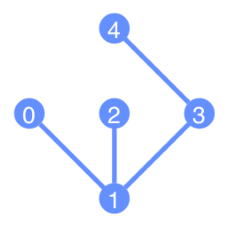

In [131]:
from qiskit import QuantumCircuit, execute, transpile, transpiler
from qiskit.visualization import plot_error_map, plot_gate_map
from qiskit.providers.fake_provider import FakeVigoV2, FakeVigo
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer

from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap

import scipy
import seaborn as sns
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings("ignore")

 
backend = FakeVigo()
# plot_error_map(backend)
plot_gate_map(backend)



In [132]:
CG = nx.Graph()
cp = backend.configuration().to_dict()['coupling_map']
for e in cp:
    CG.add_edge(e[0],e[1])

In [133]:
def count_gates(qc: QuantumCircuit):
    gate_count = { qubit: 0 for qubit in qc.qubits }
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count

def remove_idle_wires(qc: QuantumCircuit):
    qc_out = qc.copy()
    gate_count = count_gates(qc_out)
    for qubit, count in gate_count.items():
        if count == 0:
            qc_out.qubits.remove(qubit)
    return qc_out

def basic_transpile(qc):
    cmap = []
    for i in range(5):
        for j in range(5):
            if i!=j:
                cmap.append((i,j))
    cmap = transpiler.CouplingMap([list([elem[0],elem[1]]) for elem in cmap])
    all_to_all_backend = AerSimulator(coupling_map = cmap,basis_gates=['cx', 'id', 'rz', 'sx'])
    qc = transpile(qc, backend=all_to_all_backend, optimization_level=0)
    return qc

def get_ig(qc):
    qc_edges = []
    for d in qc.data:
        if 'cx' in d[0].name:
            q_ctrl, q_trgt = d[1]
            q_ctrl_index = (qc.find_bit(q_ctrl).index)
            q_trgt_index = (qc.find_bit(q_trgt).index)
            qc_edges.append((q_ctrl_index, q_trgt_index))
    IG = nx.Graph()
    for e in qc_edges:
        IG.add_edge(e[0],e[1])
    return IG

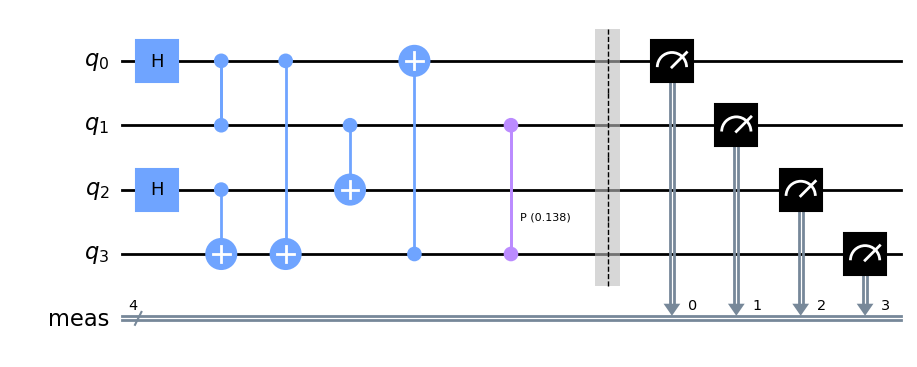

In [134]:
qc_not_isomorphic = QuantumCircuit(4)
qc_not_isomorphic.h(0)
qc_not_isomorphic.h(2)
qc_not_isomorphic.cz(0,1)
qc_not_isomorphic.cx(2,3)
qc_not_isomorphic.cx(0,3)
qc_not_isomorphic.cx(1,2)
qc_not_isomorphic.cx(3,0)
qc_not_isomorphic.cp(np.random.rand(),1,3)
qc_not_isomorphic.measure_all()
qc_not_isomorphic.draw(output='mpl')

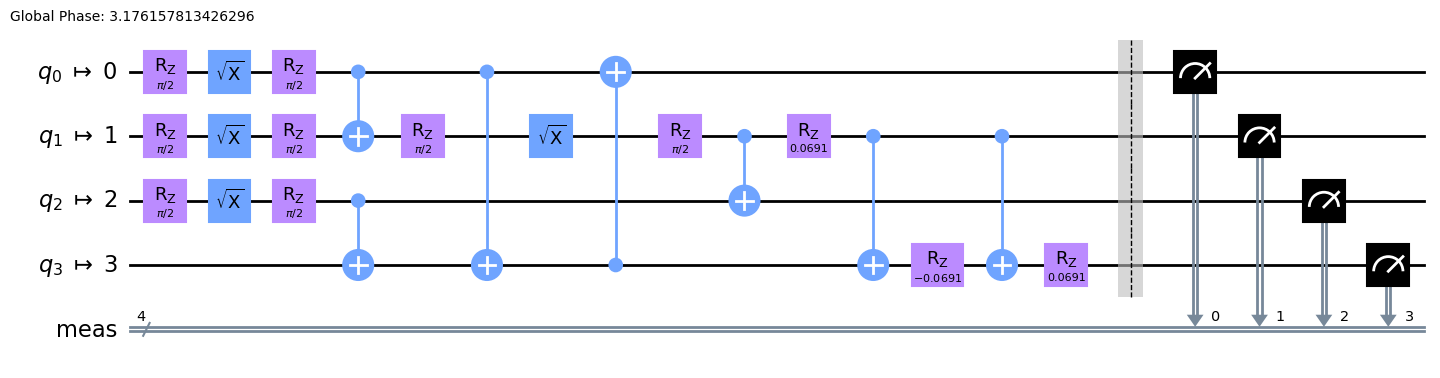

In [135]:
qc_not_isomorphic = basic_transpile(qc_not_isomorphic)
qc_not_isomorphic = remove_idle_wires(qc_not_isomorphic)
qc_not_isomorphic.draw(output='mpl')

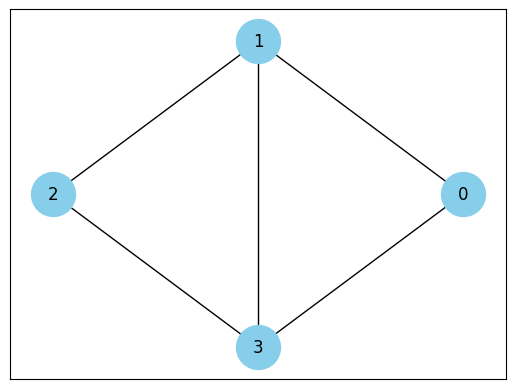

In [136]:
IG_not_isomorphic = get_ig(qc_not_isomorphic)
pos = nx.circular_layout(IG_not_isomorphic)
nx.draw_networkx(IG_not_isomorphic,pos=pos, with_labels=True, node_size=1000, node_color="skyblue")
plt.show()

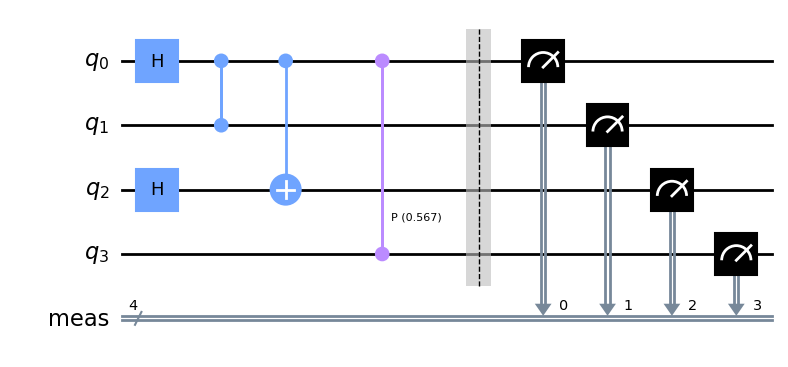

In [137]:
qc_isomorphic = QuantumCircuit(4)
qc_isomorphic.h(0)
qc_isomorphic.h(2)
qc_isomorphic.cz(0,1)
qc_isomorphic.cx(0,2)
qc_isomorphic.cp(np.random.rand(),0,3)
qc_isomorphic.measure_all()
qc_isomorphic.draw(output='mpl')

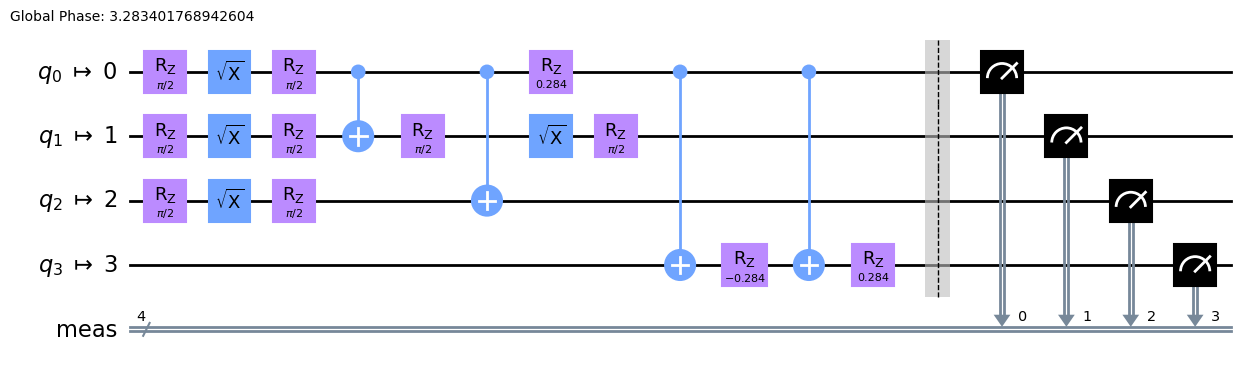

In [138]:
qc_isomorphic = basic_transpile(qc_isomorphic)
qc_isomorphic = remove_idle_wires(qc_isomorphic)
qc_isomorphic.draw(output='mpl')

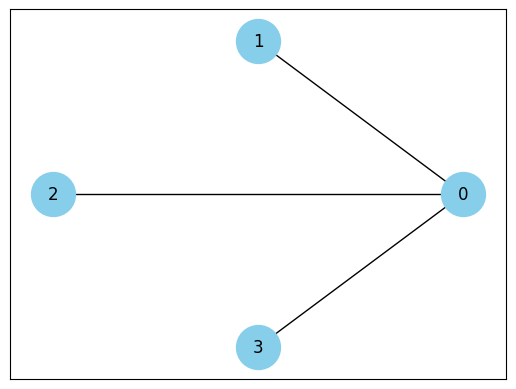

In [139]:
IG_isomorphic = get_ig(qc_isomorphic)
pos = nx.circular_layout(IG_isomorphic)
nx.draw_networkx(IG_isomorphic,pos=pos, with_labels=True, node_size=1000, node_color="skyblue")
plt.show()

#  <span style="color:red">2. Find initial mapping with VF2++ Algorithm</span>.


Check if interactive graph (Quantum Circuit) is (subgraph) isomoporphic to Coupling Map (Connectivity Graph) using VF2++ algorithm (implemented in https://networkx.org/documentation/stable/reference/algorithms/isomorphism.html)

<img src="https://i.stack.imgur.com/pXPW1.png" width="200">

True
{1: 0, 0: 1, 2: 2, 3: 3}
Quantum Circuit isomorphic to the connectivity graph
Edit distance: 0.0 , is 0 because graphs are isomorphic
Initial mapping: [(1, 0), (0, 1), (2, 2), (3, 3)]


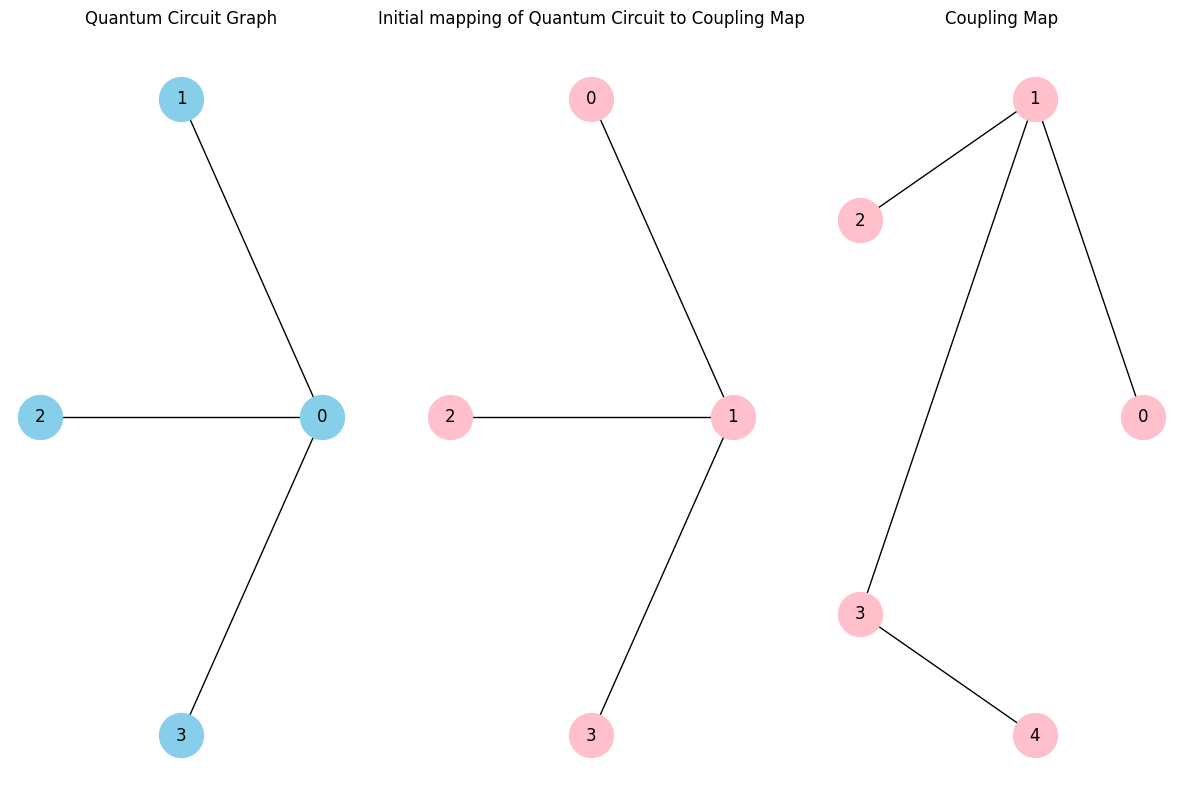

In [140]:
from networkx.algorithms.isomorphism import GraphMatcher
GM = GraphMatcher(CG,IG_isomorphic)
print(GM.subgraph_is_isomorphic())


if GM.subgraph_is_isomorphic():
    print(GM.mapping)
    print("Quantum Circuit isomorphic to the connectivity graph")
    CG_trace = CG.subgraph(GM.mapping.keys())
    distance=nx.graph_edit_distance(CG_trace,IG_isomorphic)
    print("Edit distance:",distance,", is 0 because graphs are isomorphic")
    initial_placement = [nx.nodes(CG_trace), nx.edges(CG_trace)] 
    OEP_nodes = nx.optimal_edit_paths(IG_isomorphic, CG_trace)[0][0][0]
    print("Initial mapping:",OEP_nodes)
    
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,10))
    ax = axes.flatten()
    pos = nx.circular_layout(IG_isomorphic)
    nx.draw_networkx(IG_isomorphic,pos=pos, with_labels=True, node_size=1000, node_color="skyblue", ax=ax[0])
    nx.draw_networkx(IG_isomorphic,pos=pos, with_labels=True, node_size=1000, node_color="pink", labels = GM.mapping, ax=ax[1])
    pos = nx.circular_layout(CG)
    nx.draw_networkx(CG,pos=pos, with_labels=True, node_size=1000, node_color="pink", ax=ax[2])
    
    ax[0].title.set_text('Quantum Circuit Graph')
    ax[1].title.set_text('Initial mapping of Quantum Circuit to Coupling Map')
    ax[2].title.set_text('Coupling Map')

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    plt.show()

##  <span style="color:red">If not isomorphic: Get the closest structurally similar subgraph</span>


In [141]:
GM = GraphMatcher(CG,IG_not_isomorphic)
print(GM.subgraph_is_isomorphic())

False


Generate all possible subgraphs from coupling map with the number of nodes as number of qubits in the quantum circuit (i.e. nodes in the interactive graph) using https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.induced_subgraph.html

[(0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4)]


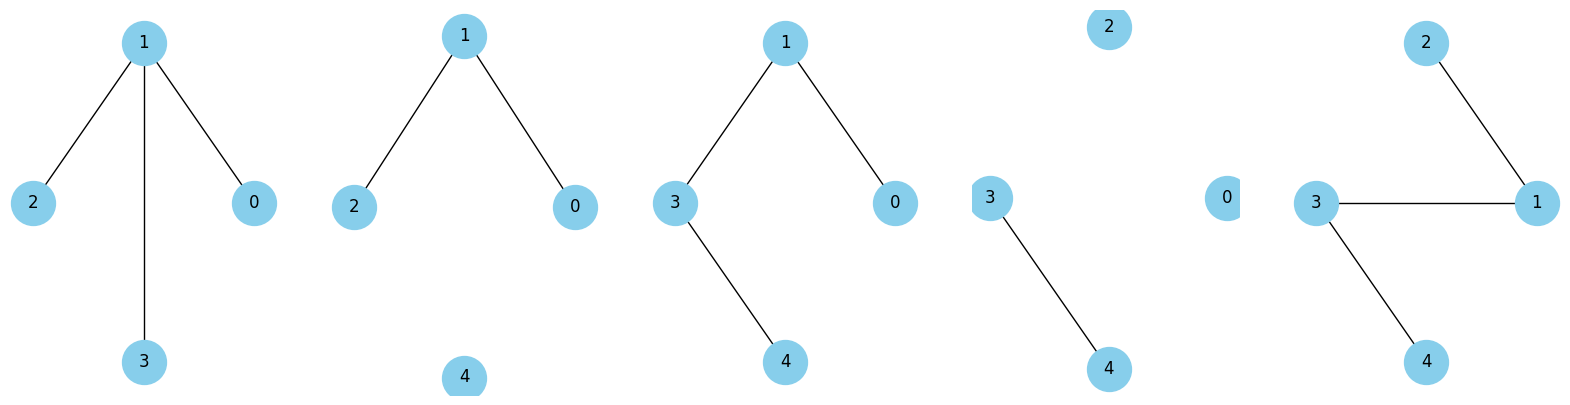

In [142]:
subgraphs = []
subgraph_list = []
#find all connected subgraphs:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(20,5))
ax = axes.flatten()
subgraphs += itertools.combinations(CG, 4)
print(subgraphs)
for i,sg in enumerate(subgraphs):
    sg = nx.induced_subgraph(CG,sg)
    subgraph_list.append(sg)
    pos = nx.circular_layout(sg)
    nx.draw_networkx(sg,pos=pos, with_labels=True, node_size=1000, node_color="skyblue",ax = ax[i])
    ax[i].set_axis_off()
plt.show()

Now, Only keep the connected ones


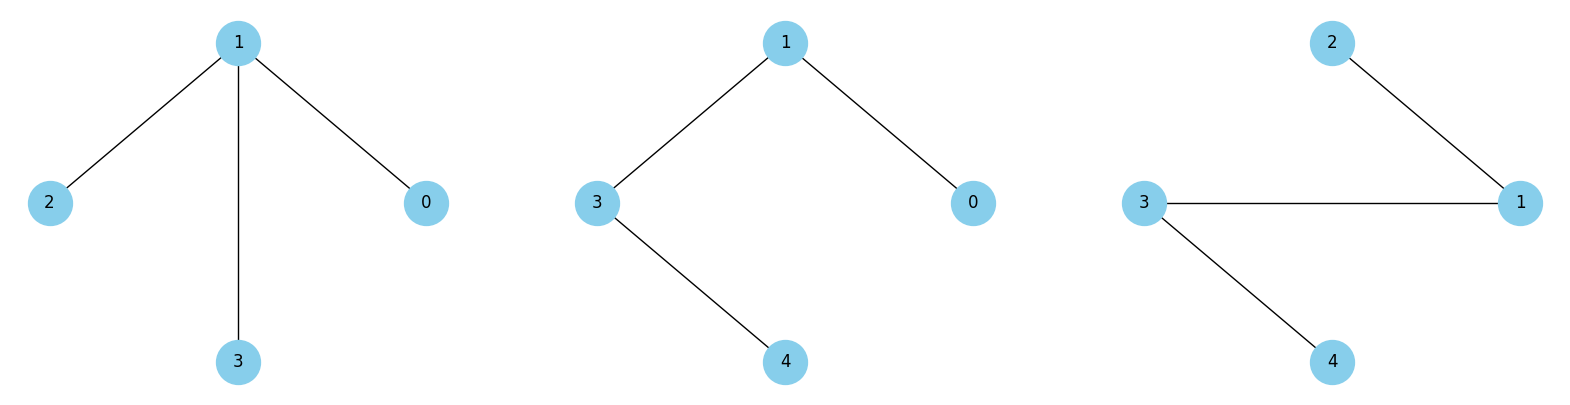

In [143]:
subgraph_list = [sg for sg in subgraph_list if nx.is_connected(sg)]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,5))
ax = axes.flatten()

for i,sg in enumerate(subgraph_list):
    pos = nx.circular_layout(sg)
    nx.draw_networkx(sg,pos=pos, with_labels=True, node_size=1000, node_color="skyblue",ax = ax[i])
    ax[i].set_axis_off()
plt.show()

sort based on degree and edges, and remove the connectivity subgraphs that are isomorphic to each other

In [144]:
 #sort the subgraphs based on number of edges, max degree and max degree in neighborhood (graph isomorphism process)
subgraph_list.sort(key=lambda x: nx.number_of_edges(x))
subgraph_list.sort(key=lambda x: max(dict(x.degree()).values()))
subgraph_list.sort(key=lambda x: max(dict(nx.average_neighbor_degree(x)).values()))

In [145]:
if len(subgraph_list) > 1:
    for sg, sg2 in itertools.combinations(subgraph_list,2):
        if GraphMatcher(sg,sg2).is_isomorphic() and sg2 in subgraph_list:
            subgraph_list.remove(sg2)

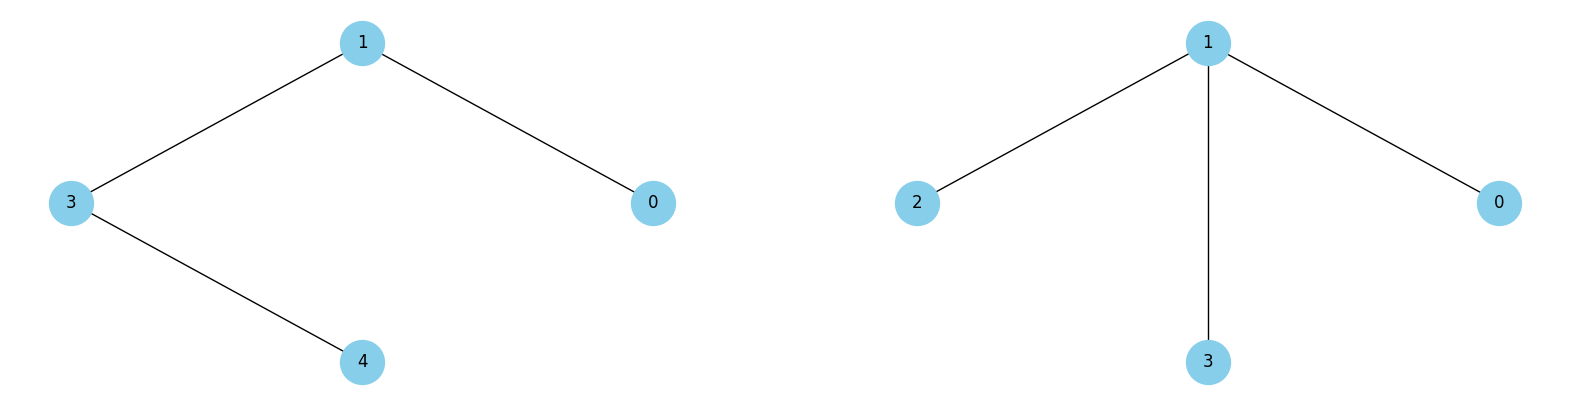

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
ax = axes.flatten()

for i,sg in enumerate(subgraph_list):
    pos = nx.circular_layout(sg)
    nx.draw_networkx(sg,pos=pos, with_labels=True, node_size=1000, node_color="skyblue",ax = ax[i])
    ax[i].set_axis_off()
plt.show()

Using A* search, find the graph-edit-distance (implemented with ```nx.graph_edit_distance``` in networkx)
to transform subgraph CGs isomorphic to IG

In [147]:
distance = 14*CG.number_of_edges()
fin_subgraph = []
for subgraph in subgraph_list:
    new_distance = nx.graph_edit_distance(subgraph,IG_isomorphic)
    print("Subgraph:",subgraph.edges,"Edit Distance:",new_distance)
    if new_distance <= distance:
        distance = new_distance
        fin_subgraph = subgraph
OEP = nx.optimal_edit_paths(fin_subgraph, IG_isomorphic)[0][0]
OEP_nodes = nx.optimal_edit_paths(IG_isomorphic, fin_subgraph)[0][0][0]
print("\n\nThe final subgraph is with nodes:", nx.nodes(fin_subgraph), "with distance: ", distance, "and edges: ", nx.edges(fin_subgraph))
initial_placement = [nx.nodes(fin_subgraph), nx.edges(fin_subgraph)]
print("Optimal edit paths: ", OEP)
print("Initial placement: ", OEP_nodes)

Subgraph: [(0, 1), (1, 3), (3, 4)] Edit Distance: 2.0
Subgraph: [(0, 1), (1, 2), (1, 3)] Edit Distance: 0.0


The final subgraph is with nodes: [0, 1, 2, 3] with distance:  0.0 and edges:  [(0, 1), (1, 2), (1, 3)]
Optimal edit paths:  ([(1, 0), (0, 1), (2, 2), (3, 3)], [((0, 1), (0, 1)), ((1, 2), (0, 2)), ((1, 3), (0, 3))])
Initial placement:  [(1, 0), (0, 1), (2, 2), (3, 3)]


```OEP[0]```: TQGs that can be directly implemented

```OEP[1]```: TQGs that cannot be directly implemented i.e. missing edges, contains the list of tuple of tuples:
    
    + 1st tuple: logical qubits in TQGs (qi,qj)    
    + 2nd tuple: most optimal way to implement them on physical qubits (pi,pj)

# 3. Generate Graph Laplacian

1. $\textbf{Calculate Graph Laplacians of connectivity graph CG and interactive graph IG: $L_{IG}$ and $L_{CG}$}$
    $$ 
    L(\mathcal{G}(\mathcal{V},\mathcal{E})) : L_{ij} =  
\begin{cases}
    deg(i),& \text{if } i = j\\
    -1,& \text{else if } (v_i,v_j) \in \mathcal{E} \\
    0,              & \text{else}
\end{cases}
 $$
 
2. $\textbf{Calculate density matrices ($\rho$) of Laplacians :}$
$$\rho_{IG} = \frac{e^{-\beta L_{IG}}}{Tr[e^{-\beta L_{IG}}]}$$
$$\rho_{CG} = \frac{e^{-\beta L_{CG}}}{Tr[e^{-\beta L_{CG}}]}$$

3. $\textbf{Vonn-Neumann Entropy of density matrix:}$

$$S(\rho) = -Tr[\rho log\rho]$$

   where $\rho$ in $Tr[\cdot]$ represents eigenvalues of density matrices 
   
4. $\textbf{quantum Jensen-Shannon divergence (qJSD):}$

$$  D_{qJSD}(\rho_{IG} || \rho_{CG}) = S\big(\frac{\rho_{IG}+\rho_{CG}}{2}\big) -\frac{1}{2}\big(S(\rho_{IG})+S(\rho_{CG})\big)$$

  qJSD is used because: 

+ it is bounded i.e. $0\leq \sqrt{D_{qJSD}(\rho_{IG} || \rho_{CG})} \leq 1$. 0 when $\rho_{IG} = \rho_{CG}$, and 1 when $\rho_{IG} \perp \rho_{CG}$
+ is symmetric $ D_{qJSD}(\rho_{IG} || \rho_{CG}) = D_{qJSD}(\rho_{CG} || \rho_{IG})$
+ is non-increasing under the action of CP (Completely Positive) maps: $ D_{qJSD}(\rho_{IG} || \rho_{CG}) \leq D_{qJSD}(\Phi({\rho_{IG})} || \Phi({\rho_{CG}})) $

5. $\textbf{CPTP maps for edge removal from $\rho_{IG}$}$

After $i_{th}$ iteration of edge removal, let the state of $\rho_{IG}$ be $\rho^{i}_{IG}$:

$$ \rho^{i}_{IG} = \Pi_{\bar{E}} \rho_{IG} \Pi_{\bar{E}}$$

where, $\bar{E}$ represents edges present in IG (Quantum Circuit) but absent in Connectivity graph

Before we could remove the trivial edge i.e. edge present in both the IG and CG: we apply $\Phi$, a CPTP map on the $\rho_{CG}$:


Using Birkhoff-Vonn-Neumann theorem, CPTP (Completely Positive Trace Preserving) maps can be decomposed into linear combination of permutations matrices}:

$$ \phi(\rho_{CG}) = \sum_j \theta_{j} P_j \rho_{CG} P_j$$

The permutations matrices $P_j$ are limited by the connectivity of the quantum device

Once the permutation is chosen matrix is used for routing, the trivial edge (which didn't use to be trivial before) can be removed from $\rho^i_{IG} \rightarrow \rho^{i+1}_{IG} $  and from $\rho_{CG}$ signified by $\Pi$ in the following equation:

$$\Pi_i\{ min_{\bar{\theta}}[ D_{qJSD}(\rho^i_{IG})|| \Pi_{\theta_{max}}(\Phi(\rho_{CG})) ]\} \geq 0$$ 

Essentially, $\Pi$ just sets the $\rho_{ij}=0$ for $(i,j)$ which were erased

Therefore, overall constraint becomes:

$$\Pi_i\{ min_{l_i} \{ min_{\bar{\theta}}[ D_{qJSD}(\rho^i_{IG})|| \zeta ^ {\circ l_i} (\rho_{CG})) ]\}\} \geq 0$$ 

where, $\zeta ^ {\circ l_i} (\cdot)= \Pi^{l_i}_{\theta_{max}}(\Phi^{l_i}(...\Pi^{1}_{\theta_{max}}(\Phi^{1}(\cdot)))$, $l^i$ represents the $l_i^{th}$ superoperator composition for $i^{th}$ remaining sub-system interaction in $\rho^i_{IG}$. At the end of all iterations, $\rho^i_{IG} = I$


6. $\textbf{Finally, the lower bound on SWAPs is given by SWAP uncomplexity:}$
$$U_{SWAP} = \sum_i l_i$$

In [129]:
# def rho(G, beta = 0.02):
#     L = nx.laplacian_matrix(G).toarray()
#     rho_L = scipy.linalg.expm(-beta*L)
#     Z = np.trace(rho_L)
#     return rho_L/Z
# def S(rho):
#     return sum(np.linalg.eig(rho)[0]*np.log2(np.linalg.eig(rho)[0]))
# def Q_jsd(rho_ig,rho_cg): 
#     return S((rho_ig+rho_cg)/2)-(S(rho_ig)+S(rho_cg))/2

# rho_CG = rho(CG)
# rho_IG = rho(IG)